In [1]:
import config
import os
import random
import utils

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# For RNN model
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

# For hyperopt (parameter optimization)
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
from hyperopt.pyll.base import scope  # quniform returns float, some parameters require int; use this to force int

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

%matplotlib inline

In [2]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
def format_scale_data(data, weeks=1):
    X_total = data.values

    data = X_total[(53-weeks):, :]
    print(data.shape)
    scaler, values = utils.scale(data)
    values = utils.series_to_supervised(values, n_in=weeks, n_out=1, dropnan=True).values

    y_scaler, y = utils.scale(data[:, 1].reshape((len(data), 1)))

    train = values[:140, :]
    valid1 = values[140:144, :]
    valid2 = values[144:148, :]
    test = values[148:, :]
    

    features = 13
    obs = weeks*features

    y = values[:, -features:]

    trainX = train[:, :obs]
    trainY = train[:, -features:][:, 1]
    validX1 = valid1[:, :obs]
    validY1 = valid1[:, -features:][:, 1]
    validX2 = valid2[:, :obs]
    validY2 = valid2[:, -features:][:, 1]
    testX = test[:, :obs]
    testY = test[:, -features:][:, 1]

    trainX = trainX.reshape((trainX.shape[0], weeks, features))
    validX1 = validX1.reshape((validX1.shape[0], weeks, features))
    validX2 = validX2.reshape((validX2.shape[0], weeks, features))
    testX = testX.reshape((testX.shape[0], weeks, features))
    
    print(trainX.shape, validX1.shape, validX2.shape, testX.shape)

    return trainX, trainY, validX1, validY1, validX2, validY2, testX, testY, scaler, y_scaler

In [14]:
def run():
    def f_nn(params):
        # Generate data with given window
        saltlake_week = pd.read_csv('../saltlake_week.csv')
        data = saltlake_week[['Cases', 'VMT (Veh-Miles)', 'News Sentiment', 'Unemployment Rate', 'PRCP', 'SNWD',
                              'Percent_Fully_Vaccinated_5&Older', 'TAVG',
                              'Stay at Home', 'Mask', 'School Opening', 'Health Emergency', 'Holiday']]
        trainX, trainY, validX1, validY1, validX2, validY2, testX, testY, scaler, y_scaler = format_scale_data(data=data, 
                                                                                                               weeks=params['weeks'])
        
        # Keras LSTM model
        model = Sequential()

        model.add(SimpleRNN(units=params['units_1'], input_shape=(trainX.shape[1], trainX.shape[2]),
                       activation='relu', return_sequences=True))                
        model.add(Dropout(rate=params['dropout']))
        model.add(SimpleRNN(units=params['units_2'],
                       activation='relu', return_sequences=True))                
        model.add(Dropout(rate=params['dropout']))
        model.add(SimpleRNN(units=params['units_3'],
                       activation='relu', return_sequences=True))                
        model.add(Dropout(rate=params['dropout']))
        model.add(SimpleRNN(units=params['units_4'],
                       activation='relu'))                
        model.add(Dropout(rate=params['dropout']))
        model.add(Dense(1))
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=params['learning_rate']), 
                      loss='mean_squared_error', metrics=['mse', 'mape'])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

        result = model.fit(trainX, trainY, verbose=0, validation_data=(validX1, validY1),
                            batch_size=4,
                            epochs=200,
                            callbacks=[es, TqdmCallback(verbose=1)]
                            )

        # get the lowest validation loss of the training epochs
        validation_loss = np.amin(result.history['val_loss'])
        print('Best validation loss of epoch:', validation_loss)


        return {'loss': validation_loss, 'status': STATUS_OK, 'model': model, 'params': params}

    # hyperparameters to search over with hyperopt
    space = {'dropout': hp.uniform('dropout', 0.01, 0.5),
             'units_1': scope.int(hp.quniform('units_1', 8, 128, 4)),
             'units_2': scope.int(hp.quniform('units_2', 8, 128, 4)),
             'units_3': scope.int(hp.quniform('units_3', 8, 128, 4)),
             'units_4': scope.int(hp.quniform('units_4', 8, 128, 4)),
             'weeks': scope.int(hp.quniform('weeks', 1, 10, 1)),
             'learning_rate': hp.uniform('learning_rate', 0.001, 0.1)
             }

    trials = Trials()
    best = fmin(f_nn, space, algo=tpe.suggest, max_evals=50, trials=trials)

    # get best model
    best_model = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']
    best_params = trials.results[np.argmin([r['loss'] for r in trials.results])]['params']

    print(best_params)
    print(best_model.summary())
    best_model.save('Model/RNN-4')
    
    saltlake_week = pd.read_csv('../saltlake_week.csv')
    data = saltlake_week[['Cases', 'VMT (Veh-Miles)', 'News Sentiment', 'Unemployment Rate', 'PRCP', 'SNWD',
                          'Percent_Fully_Vaccinated_5&Older', 'TAVG', 
                          'Stay at Home', 'Mask', 'School Opening', 'Health Emergency', 'Holiday']]
    trainX, trainY, validX1, validY1, validX2, validY2, testX, testY, scaler, y_scaler = format_scale_data(data=data, 
                                                                                                            weeks=best_params['weeks'])
    
    best_model.evaluate(validX2, validY2)
    
    yhat_valid2 = best_model.predict(validX2)
    yhat_valid2_inv = y_scaler.inverse_transform(yhat_valid2)
    validY2_inv = y_scaler.inverse_transform(validY2.reshape((-1, 1)))
    
    print(yhat_valid2.shape)
    print(yhat_valid2_inv.shape)
    print(validY2_inv.shape)
    
    yhat_train = best_model.predict(trainX)
    yhat_train_inv = y_scaler.inverse_transform(yhat_train)
    trainY_inv = y_scaler.inverse_transform(trainY.reshape((-1, 1)))
    
    print("Mean Squared Error: {}".format(mean_squared_error(validY2_inv, yhat_valid2_inv)))
    print("Root Mean Squared Error: {}".format(mean_squared_error(validY2_inv, yhat_valid2_inv, squared=False)))
    print("Mean Absolute Percentage Error: {}".format(mean_absolute_percentage_error(validY2_inv, yhat_valid2_inv)))
    
    plt.figure()
    plt.plot(yhat_valid2_inv, label='Predicted')
    plt.plot(validY2_inv, label='True')
    plt.legend()
    plt.title("Validation Data 2")
    plt.show()
    
    plt.figure()
    plt.plot(yhat_train_inv, label='Predicted')
    plt.plot(trainY_inv, label='True')
    plt.legend()
    plt.title("Training Data")
    plt.show()
    
    return best_model

(162, 13)                                             
(140, 6, 13)                                          
(4, 6, 13)                                            
(4, 6, 13)                                            
(8, 6, 13)                                            
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping                           
Best validation loss of epoch:                        
0.0014946518931537867                                 
(158, 13)                                                                          
(140, 2, 13)                                                                       
(4, 2, 13)                                                                         
(4, 2, 13)                                                                         
(8, 2, 13)                                                                         
  2%|▏         | 1/50 [00:09<07:25,  9.09s/trial, best loss: 0.0014946518931537867]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00025: early stopping                                                        
Best validation loss of epoch:                                                     
0.00435187853872776                                                                
(164, 13)                                                                          
(140, 8, 13)                                                                       
(4, 8, 13)                                                                         
(4, 8, 13)                                                                         
(8, 8, 13)                                                                         
  4%|▍         | 2/50 [00:28<12:06, 15.13s/trial, best loss: 0.0014946518931537867]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00021: early stopping                                                        
Best validation loss of epoch:                                                     
0.0022038528695702553                                                              
(166, 13)                                                                          
(140, 10, 13)                                                                      
(4, 10, 13)                                                                        
(4, 10, 13)                                                                        
(8, 10, 13)                                                                        
  6%|▌         | 3/50 [00:39<10:17, 13.13s/trial, best loss: 0.0014946518931537867]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00024: early stopping                                                        
Best validation loss of epoch:                                                     
0.00021320118685252964                                                             
(162, 13)                                                                           
(140, 6, 13)                                                                        
(4, 6, 13)                                                                          
(4, 6, 13)                                                                          
(8, 6, 13)                                                                          
  8%|▊         | 4/50 [00:52<10:08, 13.23s/trial, best loss: 0.00021320118685252964]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                             
Epoch 00017: early stopping                                                         
Best validation loss of epoch:                                                      
4.80951857753098e-05                                                                
(164, 13)                                                                           
(140, 8, 13)                                                                      
(4, 8, 13)                                                                        
(4, 8, 13)                                                                        
(8, 8, 13)                                                                        
 10%|█         | 5/50 [01:03<09:09, 12.22s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                           
Epoch 00011: early stopping                                                       
Best validation loss of epoch:                                                    
0.0009840114507824183                                                             
(165, 13)                                                                         
(140, 9, 13)                                                                      
(4, 9, 13)                                                                        
(4, 9, 13)                                                                        
(8, 9, 13)                                                                        
 12%|█▏        | 6/50 [01:11<08:02, 10.97s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                           
Epoch 00011: early stopping                                                       
Best validation loss of epoch:                                                    
nan                                                                               
(161, 13)                                                                         
(140, 5, 13)                                                                      
(4, 5, 13)                                                                        
(4, 5, 13)                                                                        
(8, 5, 13)                                                                        
 14%|█▍        | 7/50 [01:20<07:24, 10.35s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                           
Epoch 00017: early stopping                                                       
Best validation loss of epoch:                                                    
1.0991439819335938                                                                
(158, 13)                                                                         
(140, 2, 13)                                                                      
(4, 2, 13)                                                                        
(4, 2, 13)                                                                        
(8, 2, 13)                                                                        
 16%|█▌        | 8/50 [01:29<06:57,  9.93s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                           
Epoch 00014: early stopping                                                       
Best validation loss of epoch:                                                    
0.002987738000229001                                                              
(163, 13)                                                                         
(140, 7, 13)                                                                      
(4, 7, 13)                                                                        
(4, 7, 13)                                                                        
(8, 7, 13)                                                                        
 18%|█▊        | 9/50 [01:36<06:04,  8.88s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                           
Epoch 00011: early stopping                                                       
Best validation loss of epoch:                                                    
0.09293979406356812                                                               
(164, 13)                                                                          
(140, 8, 13)                                                                       
(4, 8, 13)                                                                         
(4, 8, 13)                                                                         
(8, 8, 13)                                                                         
 20%|██        | 10/50 [01:44<05:48,  8.71s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00032: early stopping                                                        
Best validation loss of epoch:                                                     
0.0007487713592126966                                                              
(164, 13)                                                                          
(140, 8, 13)                                                                       
(4, 8, 13)                                                                         
(4, 8, 13)                                                                         
(8, 8, 13)                                                                         
 22%|██▏       | 11/50 [01:59<06:57, 10.70s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00011: early stopping                                                        
Best validation loss of epoch:                                                     
nan                                                                                
(161, 13)                                                                          
(140, 5, 13)                                                                       
(4, 5, 13)                                                                         
(4, 5, 13)                                                                         
(8, 5, 13)                                                                         
 24%|██▍       | 12/50 [02:06<06:03,  9.57s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00038: early stopping                                                        
Best validation loss of epoch:                                                     
0.06193690374493599                                                                
(162, 13)                                                                          
(140, 6, 13)                                                                       
(4, 6, 13)                                                                         
(4, 6, 13)                                                                         
(8, 6, 13)                                                                         
 26%|██▌       | 13/50 [02:23<07:17, 11.84s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00027: early stopping                                                        
Best validation loss of epoch:                                                     
0.031334713101387024                                                               
(157, 13)                                                                          
(140, 1, 13)                                                                       
(4, 1, 13)                                                                         
(4, 1, 13)                                                                         
(8, 1, 13)                                                                         
 28%|██▊       | 14/50 [02:37<07:26, 12.41s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00014: early stopping                                                        
Best validation loss of epoch:                                                     
0.04310111701488495                                                                
(159, 13)                                                                          
(140, 3, 13)                                                                       
(4, 3, 13)                                                                         
(4, 3, 13)                                                                         
(8, 3, 13)                                                                         
 30%|███       | 15/50 [02:43<06:10, 10.58s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00018: early stopping                                                        
Best validation loss of epoch:                                                     
0.000310465635266155                                                               
(164, 13)                                                                          
(140, 8, 13)                                                                       
(4, 8, 13)                                                                         
(4, 8, 13)                                                                         
(8, 8, 13)                                                                         
 32%|███▏      | 16/50 [02:51<05:28,  9.66s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00021: early stopping                                                        
Best validation loss of epoch:                                                     
0.04009705036878586                                                                
(164, 13)                                                                          
(140, 8, 13)                                                                       
(4, 8, 13)                                                                         
(4, 8, 13)                                                                         
(8, 8, 13)                                                                         
 34%|███▍      | 17/50 [03:03<05:38, 10.26s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00019: early stopping                                                        
Best validation loss of epoch:                                                     
nan                                                                                
(159, 13)                                                                          
(140, 3, 13)                                                                       
(4, 3, 13)                                                                         
(4, 3, 13)                                                                         
(8, 3, 13)                                                                         
 36%|███▌      | 18/50 [03:14<05:37, 10.55s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00036: early stopping                                                        
Best validation loss of epoch:                                                     
0.0391613207757473                                                                 
(164, 13)                                                                          
(140, 8, 13)                                                                       
(4, 8, 13)                                                                         
(4, 8, 13)                                                                         
(8, 8, 13)                                                                         
 38%|███▊      | 19/50 [03:27<05:54, 11.42s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00012: early stopping                                                        
Best validation loss of epoch:                                                     
0.057726554572582245                                                               
(162, 13)                                                                          
(140, 6, 13)                                                                       
(4, 6, 13)                                                                         
(4, 6, 13)                                                                         
(8, 6, 13)                                                                         
 40%|████      | 20/50 [03:38<05:32, 11.09s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00032: early stopping                                                        
Best validation loss of epoch:                                                     
0.0006550145917572081                                                              
(163, 13)                                                                          
(140, 7, 13)                                                                       
(4, 7, 13)                                                                         
(4, 7, 13)                                                                         
(8, 7, 13)                                                                         
 42%|████▏     | 21/50 [03:54<06:08, 12.71s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00017: early stopping                                                        
Best validation loss of epoch:                                                     
0.045165158808231354                                                               
(163, 13)                                                                          
(140, 7, 13)                                                                       
(4, 7, 13)                                                                         
(4, 7, 13)                                                                         
(8, 7, 13)                                                                         
 44%|████▍     | 22/50 [04:06<05:46, 12.38s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00013: early stopping                                                        
Best validation loss of epoch:                                                     
0.018558137118816376                                                               
(166, 13)                                                                          
(140, 10, 13)                                                                      
(4, 10, 13)                                                                        
(4, 10, 13)                                                                        
(8, 10, 13)                                                                        
 46%|████▌     | 23/50 [04:16<05:17, 11.77s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00028: early stopping                                                        
Best validation loss of epoch:                                                     
0.00032713598920963705                                                             
(166, 13)                                                                          
(140, 10, 13)                                                                      
(4, 10, 13)                                                                        
(4, 10, 13)                                                                        
(8, 10, 13)                                                                        
 48%|████▊     | 24/50 [04:32<05:38, 13.00s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00017: early stopping                                                        
Best validation loss of epoch:                                                     
0.0007869620458222926                                                              
(165, 13)                                                                          
(140, 9, 13)                                                                       
(4, 9, 13)                                                                         
(4, 9, 13)                                                                         
(8, 9, 13)                                                                         
 50%|█████     | 25/50 [04:43<05:11, 12.47s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00029: early stopping                                                        
Best validation loss of epoch:                                                     
0.0008554861415177584                                                              
(160, 13)                                                                          
(140, 4, 13)                                                                       
(4, 4, 13)                                                                         
(4, 4, 13)                                                                         
(8, 4, 13)                                                                         
 52%|█████▏    | 26/50 [05:01<05:38, 14.08s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00017: early stopping                                                        
Best validation loss of epoch:                                                     
0.0003902223543263972                                                              
(165, 13)                                                                          
(140, 9, 13)                                                                       
(4, 9, 13)                                                                         
(4, 9, 13)                                                                         
(8, 9, 13)                                                                         
 54%|█████▍    | 27/50 [05:10<04:45, 12.42s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00011: early stopping                                                        
Best validation loss of epoch:                                                     
0.0026527740992605686                                                              
(160, 13)                                                                          
(140, 4, 13)                                                                       
(4, 4, 13)                                                                         
(4, 4, 13)                                                                         
(8, 4, 13)                                                                         
 56%|█████▌    | 28/50 [05:18<04:08, 11.32s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00018: early stopping                                                        
Best validation loss of epoch:                                                     
0.026049859821796417                                                               
(165, 13)                                                                          
(140, 9, 13)                                                                       
(4, 9, 13)                                                                         
(4, 9, 13)                                                                         
(8, 9, 13)                                                                         
 58%|█████▊    | 29/50 [05:29<03:51, 11.03s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00014: early stopping                                                        
Best validation loss of epoch:                                                     
0.0005079646361991763                                                              
(157, 13)                                                                          
(140, 1, 13)                                                                       
(4, 1, 13)                                                                         
(4, 1, 13)                                                                         
(8, 1, 13)                                                                         
 60%|██████    | 30/50 [05:42<03:52, 11.63s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00011: early stopping                                                        
Best validation loss of epoch:                                                     
0.023289527744054794                                                               
(166, 13)                                                                          
(140, 10, 13)                                                                      
(4, 10, 13)                                                                        
(4, 10, 13)                                                                        
(8, 10, 13)                                                                        
 62%|██████▏   | 31/50 [05:47<03:07,  9.87s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00028: early stopping                                                        
Best validation loss of epoch:                                                     
0.0004875505983363837                                                              
(162, 13)                                                                          
(140, 6, 13)                                                                       
(4, 6, 13)                                                                         
(4, 6, 13)                                                                         
(8, 6, 13)                                                                         
 64%|██████▍   | 32/50 [06:04<03:32, 11.81s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00015: early stopping                                                        
Best validation loss of epoch:                                                     
0.00021778531663585454                                                             
(160, 13)                                                                          
(140, 4, 13)                                                                       
(4, 4, 13)                                                                         
(4, 4, 13)                                                                         
(8, 4, 13)                                                                         
 66%|██████▌   | 33/50 [06:13<03:05, 10.90s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00025: early stopping                                                        
Best validation loss of epoch:                                                     
0.00010975923942169175                                                             
(160, 13)                                                                          
(140, 4, 13)                                                                       
(4, 4, 13)                                                                         
(4, 4, 13)                                                                         
(8, 4, 13)                                                                         
 68%|██████▊   | 34/50 [06:24<02:55, 10.97s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00018: early stopping                                                        
Best validation loss of epoch:                                                     
0.0007051338907331228                                                              
(159, 13)                                                                          
(140, 3, 13)                                                                       
(4, 3, 13)                                                                         
(4, 3, 13)                                                                         
(8, 3, 13)                                                                         
 70%|███████   | 35/50 [06:33<02:38, 10.54s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00021: early stopping                                                        
Best validation loss of epoch:                                                     
0.009638150222599506                                                               
(161, 13)                                                                          
(140, 5, 13)                                                                       
(4, 5, 13)                                                                         
(4, 5, 13)                                                                         
(8, 5, 13)                                                                         
 72%|███████▏  | 36/50 [06:43<02:23, 10.28s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00027: early stopping                                                        
Best validation loss of epoch:                                                     
0.04744607210159302                                                                
(158, 13)                                                                          
(140, 2, 13)                                                                       
(4, 2, 13)                                                                         
(4, 2, 13)                                                                         
(8, 2, 13)                                                                         
 74%|███████▍  | 37/50 [06:56<02:25, 11.21s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00012: early stopping                                                        
Best validation loss of epoch:                                                     
0.04077839478850365                                                                
(160, 13)                                                                          
(140, 4, 13)                                                                       
(4, 4, 13)                                                                         
(4, 4, 13)                                                                         
(8, 4, 13)                                                                         
 76%|███████▌  | 38/50 [07:07<02:12, 11.03s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00028: early stopping                                                        
Best validation loss of epoch:                                                     
7.340096635743976e-05                                                              
(161, 13)                                                                          
(140, 5, 13)                                                                       
(4, 5, 13)                                                                         
(4, 5, 13)                                                                         
(8, 5, 13)                                                                         
 78%|███████▊  | 39/50 [07:18<02:03, 11.19s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00027: early stopping                                                        
Best validation loss of epoch:                                                     
0.03398451209068298                                                                
(158, 13)                                                                          
(140, 2, 13)                                                                       
(4, 2, 13)                                                                         
(4, 2, 13)                                                                         
(8, 2, 13)                                                                         
 80%|████████  | 40/50 [07:32<01:59, 11.96s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00012: early stopping                                                        
Best validation loss of epoch:                                                     
0.02055433578789234                                                                
(163, 13)                                                                          
(140, 7, 13)                                                                       
(4, 7, 13)                                                                         
(4, 7, 13)                                                                         
(8, 7, 13)                                                                         
 82%|████████▏ | 41/50 [07:40<01:35, 10.60s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00015: early stopping                                                        
Best validation loss of epoch:                                                     
0.0003039727744180709                                                              
(161, 13)                                                                          
(140, 5, 13)                                                                       
(4, 5, 13)                                                                         
(4, 5, 13)                                                                         
(8, 5, 13)                                                                         
 84%|████████▍ | 42/50 [07:51<01:26, 10.79s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00017: early stopping                                                        
Best validation loss of epoch:                                                     
0.0015529785305261612                                                              
(162, 13)                                                                          
(140, 6, 13)                                                                       
(4, 6, 13)                                                                         
(4, 6, 13)                                                                         
(8, 6, 13)                                                                         
 86%|████████▌ | 43/50 [08:01<01:13, 10.57s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00011: early stopping                                                        
Best validation loss of epoch:                                                     
0.024794433265924454                                                               
(159, 13)                                                                          
(140, 3, 13)                                                                       
(4, 3, 13)                                                                         
(4, 3, 13)                                                                         
(8, 3, 13)                                                                         
 88%|████████▊ | 44/50 [08:10<01:00, 10.02s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00011: early stopping                                                        
Best validation loss of epoch:                                                     
0.013756446540355682                                                               
(160, 13)                                                                          
(140, 4, 13)                                                                       
(4, 4, 13)                                                                         
(4, 4, 13)                                                                         
(8, 4, 13)                                                                         
 90%|█████████ | 45/50 [08:17<00:46,  9.25s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00011: early stopping                                                        
Best validation loss of epoch:                                                     
0.438618540763855                                                                  
(161, 13)                                                                          
(140, 5, 13)                                                                       
(4, 5, 13)                                                                         
(4, 5, 13)                                                                         
(8, 5, 13)                                                                         
 92%|█████████▏| 46/50 [08:24<00:34,  8.66s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00023: early stopping                                                        
Best validation loss of epoch:                                                     
0.000428178085712716                                                               
(157, 13)                                                                          
(140, 1, 13)                                                                       
(4, 1, 13)                                                                         
(4, 1, 13)                                                                         
(8, 1, 13)                                                                         
 94%|█████████▍| 47/50 [08:41<00:32, 10.93s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00019: early stopping                                                        
Best validation loss of epoch:                                                     
0.00022541102953255177                                                             
(158, 13)                                                                          
(140, 2, 13)                                                                       
(4, 2, 13)                                                                         
(4, 2, 13)                                                                         
(8, 2, 13)                                                                         
 96%|█████████▌| 48/50 [08:48<00:19,  9.94s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00014: early stopping                                                        
Best validation loss of epoch:                                                     
0.04616452008485794                                                                
(162, 13)                                                                          
(140, 6, 13)                                                                       
(4, 6, 13)                                                                         
(4, 6, 13)                                                                         
(8, 6, 13)                                                                         
 98%|█████████▊| 49/50 [08:55<00:08,  8.97s/trial, best loss: 4.80951857753098e-05]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch.                            
Epoch 00019: early stopping                                                        
Best validation loss of epoch:                                                     
0.03448715806007385                                                                
100%|██████████| 50/50 [09:07<00:00, 10.94s/trial, best loss: 4.80951857753098e-05]
{'dropout': 0.2930822546516494, 'learning_rate': 0.07023865407918009, 'units_1': 120, 'units_2': 80, 'units_3': 44, 'units_4': 56, 'weeks': 9}
Model: "sequential_207"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_527 (SimpleRNN)   (None, 9, 120)            16080     
_________________________________________________________________
dropout_526 (Dropout)        (None, 9, 120)            0         
_________________________________________________________________
simple_rnn_528 (S

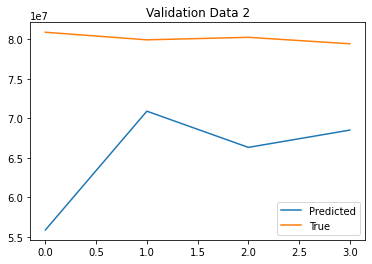

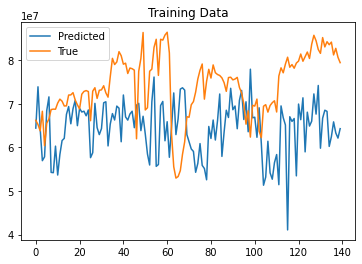

In [15]:
rnn4 = run()